# 1.Imports

In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import sklearn
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
from tensorflow.keras.optimizers import Adam
from keras_tuner import HyperModel
from keras_tuner import HyperParameters
from keras_tuner import RandomSearch
from keras.utils import  to_categorical
from sklearn.model_selection import train_test_split
import zipfile
from PIL import Image
import io
import os
import random

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Read the input files
train_df = pd.read_csv('train.csv.zip')
test_df = pd.read_csv('test.csv.zip')


In [3]:
# read the images file
file_name = "images.zip"

# opening the zip file in READ mode
with zipfile.ZipFile(file_name, 'r') as zip:
    # get a list of all archived file names from the zip
    image_names= zip.namelist()
    # use a list comprehension to get a list of image filenames (with .jpg extensions)
    list_of_image_filenames = [filename for filename in image_names if filename.endswith(('.jpg'))]

    print(f'The number of images in the zip file is: {len(list_of_image_filenames)}')

The number of images in the zip file is: 1584


# 2. Data Exploration

In [4]:
train_df.shape

(990, 194)

In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 990 entries, 0 to 989
Columns: 194 entries, id to texture64
dtypes: float64(192), int64(1), object(1)
memory usage: 1.5+ MB


In [6]:
# Checking for missing values
train_df.isna().sum().max()

0

In [7]:
# Checking for duplicates()
train_df.duplicated().sum()

0

In [8]:
train_df.dtypes

id             int64
species       object
margin1      float64
margin2      float64
margin3      float64
              ...   
texture60    float64
texture61    float64
texture62    float64
texture63    float64
texture64    float64
Length: 194, dtype: object

In [9]:
train_df.describe()

,id,margin1,margin2,margin3,margin4,margin5,margin6,margin7,margin8,margin9,...,texture55,texture56,texture57,texture58,texture59,texture60,texture61,texture62,texture63,texture64
count,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,...,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000
mean,799.595960,0.017412,0.028539,0.031988,0.023280,0.014264,0.038579,0.019202,0.001083,0.007167,...,0.036501,0.005024,0.015944,0.011586,0.016108,0.014017,0.002688,0.020291,0.008989,0.019420
std,452.477568,0.019739,0.038855,0.025847,0.028411,0.018390,0.052030,0.017511,0.002743,0.008933,...,0.063403,0.019321,0.023214,0.025040,0.015335,0.060151,0.011415,0.039040,0.013791,0.022768
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,415.250000,0.001953,0.001953,0.013672,0.005859,0.001953,0.000000,0.005859,0.000000,0.001953,...,0.000000,0.000000,0.000977,0.000000,0.004883,0.000000,0.000000,0.000000,0.000000,0.000977
50%,802.500000,0.009766,0.011719,0.025391,0.013672,0.007812,0.015625,0.015625,0.000000,0.005859,...,0.004883,0.000000,0.005859,0.000977,0.012695,0.000000,0.000000,0.003906,0.002930,0.011719
75%,1195.500000,0.025391,0.041016,0.044922,0.029297,0.017578,0.056153,0.029297,0.000000,0.007812,...,0.043701,0.000000,0.022217,0.009766,0.021484,0.000000,0.000000,0.023438,0.012695,0.029297
max,1584.000000,0.087891,0.205080,0.156250,0.169920,0.111330,0.310550,0.091797,0.031250,0.076172,...,0.429690,0.202150,0.172850,0.200200,0.106450,0.578130,0.151370,0.375980,0.086914,0.141600


In [10]:
train_df.head()

,id,species,margin1,margin2,margin3,margin4,margin5,margin6,margin7,margin8,...,texture55,texture56,texture57,texture58,texture59,texture60,texture61,texture62,texture63,texture64
0,1,Acer_Opalus,0.007812,0.023438,0.023438,0.003906,0.011719,0.009766,0.027344,0.0,...,0.007812,0.000000,0.002930,0.002930,0.035156,0.0,0.0,0.004883,0.000000,0.025391
1,2,Pterocarya_Stenoptera,0.005859,0.000000,0.031250,0.015625,0.025391,0.001953,0.019531,0.0,...,0.000977,0.000000,0.000000,0.000977,0.023438,0.0,0.0,0.000977,0.039062,0.022461
2,3,Quercus_Hartwissiana,0.005859,0.009766,0.019531,0.007812,0.003906,0.005859,0.068359,0.0,...,0.154300,0.000000,0.005859,0.000977,0.007812,0.0,0.0,0.000000,0.020508,0.002930
3,5,Tilia_Tomentosa,0.000000,0.003906,0.023438,0.005859,0.021484,0.019531,0.023438,0.0,...,0.000000,0.000977,0.000000,0.000000,0.020508,0.0,0.0,0.017578,0.000000,0.047852
4,6,Quercus_Variabilis,0.005859,0.003906,0.048828,0.009766,0.013672,0.015625,0.005859,0.0,...,0.096680,0.000000,0.021484,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.031250


In [11]:
# Identifying the column names
margin_cols = train_df.columns[train_df.columns.str.contains('margin')].size
shape_cols = train_df.columns[train_df.columns.str.contains('shape')].size
texture_cols = train_df.columns[train_df.columns.str.contains('texture')].size

print('Number of columns with "margin" in their names: ', margin_cols)
print('Number of columns with "shape" in their names: ', shape_cols)
print('Number of columns with "texture" in their names: ', texture_cols)

Number of columns with "margin" in their names:  64
Number of columns with "shape" in their names:  64
Number of columns with "texture" in their names:  64


In [43]:
# Count the number of species
num_classes = train_df['species'].unique().shape[0]
num_classes

99

In [13]:
classes = train_df['species'].unique().tolist()
classes

['Acer_Opalus',
 'Pterocarya_Stenoptera',
 'Quercus_Hartwissiana',
 'Tilia_Tomentosa',
 'Quercus_Variabilis',
 'Magnolia_Salicifolia',
 'Quercus_Canariensis',
 'Quercus_Rubra',
 'Quercus_Brantii',
 'Salix_Fragilis',
 'Zelkova_Serrata',
 'Betula_Austrosinensis',
 'Quercus_Pontica',
 'Quercus_Afares',
 'Quercus_Coccifera',
 'Fagus_Sylvatica',
 'Phildelphus',
 'Acer_Palmatum',
 'Quercus_Pubescens',
 'Populus_Adenopoda',
 'Quercus_Trojana',
 'Alnus_Sieboldiana',
 'Quercus_Ilex',
 'Arundinaria_Simonii',
 'Acer_Platanoids',
 'Quercus_Phillyraeoides',
 'Cornus_Chinensis',
 'Liriodendron_Tulipifera',
 'Cytisus_Battandieri',
 'Rhododendron_x_Russellianum',
 'Alnus_Rubra',
 'Eucalyptus_Glaucescens',
 'Cercis_Siliquastrum',
 'Cotinus_Coggygria',
 'Celtis_Koraiensis',
 'Quercus_Crassifolia',
 'Quercus_Kewensis',
 'Cornus_Controversa',
 'Quercus_Pyrenaica',
 'Callicarpa_Bodinieri',
 'Quercus_Alnifolia',
 'Acer_Saccharinum',
 'Prunus_X_Shmittii',
 'Prunus_Avium',
 'Quercus_Greggii',
 'Quercus_Suber'

In [14]:
# Count the number of datapoints for every species
train_df['species'].value_counts()

species
Acer_Opalus                    10
Crataegus_Monogyna             10
Acer_Mono                      10
Magnolia_Heptapeta             10
Acer_Capillipes                10
                               ..
Alnus_Rubra                    10
Rhododendron_x_Russellianum    10
Cytisus_Battandieri            10
Liriodendron_Tulipifera        10
Sorbus_Aria                    10
Name: count, Length: 99, dtype: int64

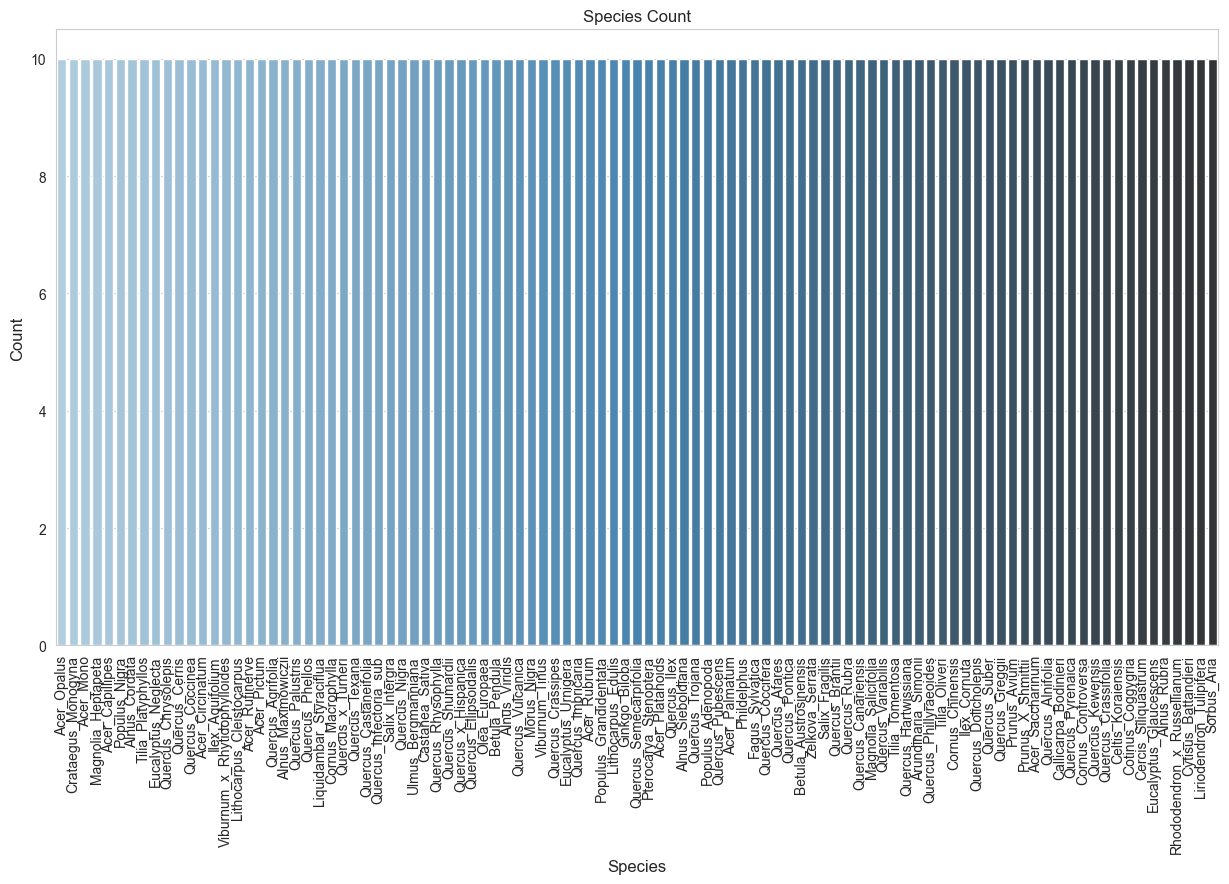

In [15]:
# Count the number of datapoints for every species
species_count = train_df['species'].value_counts()

# Plot the count for every species
plt.figure(figsize=(15,8))
sns.barplot(x = species_count.index, y = species_count.values, palette="Blues_d")
plt.title('Species Count')
plt.xticks(rotation='vertical')
plt.ylabel('Count', fontsize=12)
plt.xlabel('Species', fontsize=12)
plt.show()

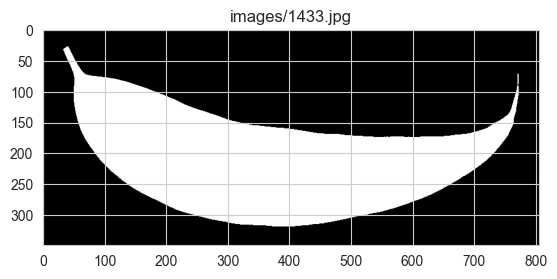

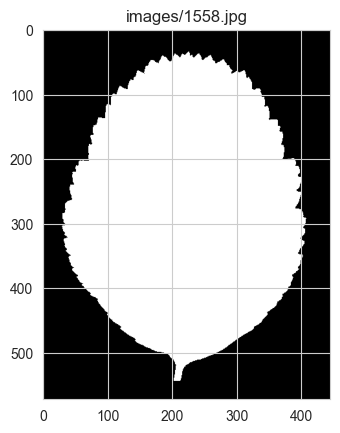

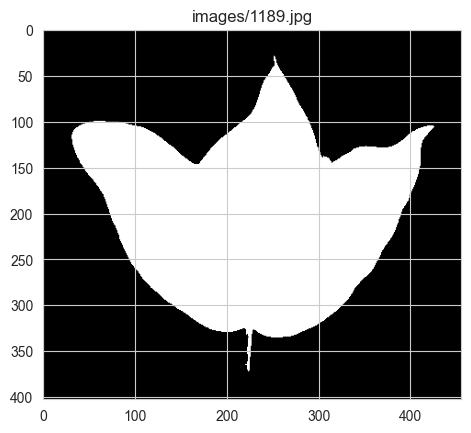

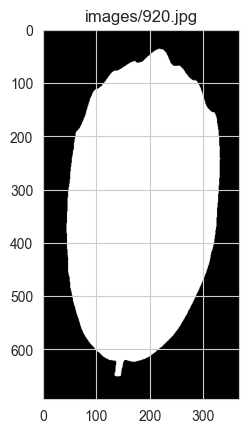

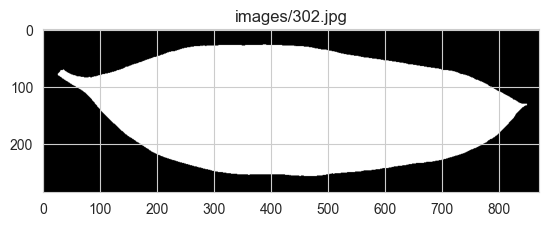

In [16]:
# Match the image filenames in the zip file with the ids in the train_df DataFrame
matched_images = [img for img in image_names if any(str(id) in img for id in train_df['id'])]

# Randomly pick 5 images
random.seed(4)
five_images = random.sample(matched_images, 5)

# Display the images
for img_name in five_images:
    with zipfile.ZipFile('images.zip', 'r') as myzip:
        with myzip.open(img_name) as myfile:
            img = Image.open(myfile)
            plt.imshow(img, cmap='gray')
            plt.title(img_name)
            plt.show()

# 3. Pre-modelling

In [54]:
# Preprocessing
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split

# Copy the original DataFrame
processed_df = train_df.copy()

# Initialize the encoder
le = LabelEncoder()

# Encode the 'species' column
processed_df['species'] = le.fit_transform(processed_df['species'])

# Initialize the scaler
scaler = MinMaxScaler()

# Scale numeric columns. Exclude 'id' and 'species' from being scaled
numeric_cols = processed_df.columns.drop(['id', 'species'])
processed_df[numeric_cols] = scaler.fit_transform(processed_df[numeric_cols])

# Split the DataFrame into features and target
X = processed_df.drop(columns=['id', 'species'])
y = processed_df['species']

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [55]:
# Print the first 5 rows of the processed DataFrame
processed_df.head()

,id,species,margin1,margin2,margin3,margin4,margin5,margin6,margin7,margin8,...,texture55,texture56,texture57,texture58,texture59,texture60,texture61,texture62,texture63,texture64
0,1,3,0.088883,0.114287,0.150003,0.022987,0.105264,0.031447,0.297875,0.0,...,0.018181,0.000000,0.016951,0.014635,0.330258,0.0,0.0,0.012987,0.000000,0.179315
1,2,49,0.066662,0.000000,0.200000,0.091955,0.228070,0.006289,0.212763,0.0,...,0.002274,0.000000,0.000000,0.004880,0.220178,0.0,0.0,0.002599,0.449433,0.158623
2,3,65,0.066662,0.047620,0.124998,0.045975,0.035085,0.018867,0.744676,0.0,...,0.359096,0.000000,0.033896,0.004880,0.073387,0.0,0.0,0.000000,0.235957,0.020692
3,5,94,0.000000,0.019046,0.150003,0.034481,0.192976,0.062892,0.255324,0.0,...,0.000000,0.004833,0.000000,0.000000,0.192654,0.0,0.0,0.046752,0.000000,0.337938
4,6,84,0.066662,0.019046,0.312499,0.057474,0.122806,0.050314,0.063826,0.0,...,0.224999,0.000000,0.124293,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.220692


# 4. Modelling

In [61]:
# Reshape the data
def reshape_for_cnn(X, n_channels):
    dim = int(np.sqrt(X.shape[1] // n_channels))
    return X.values.reshape(-1, dim, dim, n_channels)

# Define number of channels
n_channels = 3  # margin, shape, texture

# Reshape training, validation data
X_train_reshaped = reshape_for_cnn(X_train, n_channels)
X_val_reshaped = reshape_for_cnn(X_val, n_channels)

In [62]:
# The seed value
seed_value=1

# 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set Python built-in pseudorandom generator at a fixed value
random.seed(seed_value)

# 3. Set NumPy pseudorandom generator at a fixed value
np.random.seed(seed_value)

# 4. Set TensorFlow pseudorandom generator at a fixed value
tf.random.set_seed(seed_value)

In [63]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Function to build model
def build_model(input_shape, num_classes, conv_filters, conv_kernel_size, dense_units, dropout_rate, learning_rate):
    model = Sequential()
    model.add(Conv2D(filters=conv_filters, kernel_size=conv_kernel_size, activation='relu', input_shape=input_shape))
    model.add(Flatten())
    model.add(Dense(dense_units, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(dense_units, activation='relu')) 
    model.add(Dense(num_classes, activation='softmax'))   
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [67]:
n_channels = 3

# Hyperparameters for the three models
hp1 = {
    'input_shape': (8, 8, n_channels),
    'num_classes': 99,
    'conv_filters': 256,
    'conv_kernel_size': (3, 3), 
    'dense_units': 128,
    'dropout_rate': 0.2, 
    'learning_rate': 0.003  
}

hp2 = {
    'input_shape': (8, 8, n_channels),
    'num_classes': 99,
    'conv_filters': 256,
    'conv_kernel_size': (3, 3),
    'dense_units': 384,
    'dropout_rate': 0.4,  
    'learning_rate': 0.006 
}

hp3 = {
    'input_shape': (8, 8, n_channels),
    'num_classes': 99,
    'conv_filters': 256,
    'conv_kernel_size': (3, 3),  
    'dense_units': 384,
    'dropout_rate': 0.5,  
    'learning_rate': 0.007
}


In [68]:
# Create a list of the hyperparameters dictionaries
hps = [hp1, hp2, hp3]

# One-hot encode the target variables
y_train_encoded = to_categorical(y_train, num_classes=99)
y_val_encoded = to_categorical(y_val, num_classes=99)



In [69]:
from tensorflow.keras.utils import to_categorical

y_train_encoded = to_categorical(y_train, num_classes=num_classes)
y_val_encoded = to_categorical(y_val, num_classes=num_classes)

models, performance = [], []

for i, hp in enumerate(hps):
    model = build_model(**hp)
    history = model.fit(X_train_reshaped, y_train_encoded, validation_data=(X_val_reshaped, y_val_encoded), epochs=10)
    train_accuracy = history.history['accuracy'][-1]
    validation_accuracy = history.history['val_accuracy'][-1]
    validation_loss = model.evaluate(X_val_reshaped, y_val_encoded, verbose=0)[0]
    performance.append({'Model': i+1, 'Train Accuracy': train_accuracy, 'Validation Accuracy': validation_accuracy, 'Validation Loss': validation_loss})
    models.append(model)

performance_df = pd.DataFrame(performance)
print(performance_df)

Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.0148 - loss: 4.5754 - val_accuracy: 0.0606 - val_loss: 4.2392
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.1401 - loss: 3.6616 - val_accuracy: 0.3131 - val_loss: 2.4615
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.3969 - loss: 2.0794 - val_accuracy: 0.6212 - val_loss: 1.2403
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.6385 - loss: 1.2634 - val_accuracy: 0.7879 - val_loss: 0.6944
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.7846 - loss: 0.6950 - val_accuracy: 0.8636 - val_loss: 0.4249
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.8522 - loss: 0.5068 - val_accuracy: 0.8990 - val_loss: 0.3547
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.8916 - loss: 0.3320 - val_accuracy: 0.9293 - val_loss: 0.2218
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.9253 - loss: 0.2567 - val_accuracy: 0.9192 - v

The performance metrics of three models with varying hyperparameters reveal significant differences in their learning outcomes. Model 1 exhibits very low training and validation accuracies (4.04% and 2.53%, respectively), indicating it failed to learn effectively, coupled with a high validation loss. Model 2 shows improvement, with training and validation accuracies of 38% and 29.29%, respectively, and a reduced validation loss, suggesting better learning but still not optimal. Model 3 outperforms the others significantly, achieving high training and validation accuracies (96.84% and 94.95%, respectively) and a minimal validation loss, indicating superior learning and generalization capabilities. 

In [75]:
from sklearn.preprocessing import label_binarize

# Binarize the output
y_bin = label_binarize(y, classes=classes)

# Get the best model
best_model = models[0]

# Get the predicted probabilities from the best model
y_score = best_model.predict(X_val_reshaped)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Determine grid size for the plots
grid_size = int(np.ceil(np.sqrt(num_classes)))

# Set up figure for ROC plot
fig, axs = plt.subplots(grid_size, grid_size, figsize=(2*grid_size, 2*grid_size))
fig.suptitle('ROC Curve', fontsize=16)
for i, ax in enumerate(fig.axes):
    if i < num_classes:
        ax.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
        ax.plot([0, 1], [0, 1], 'k--')
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.set_title('Class '+str(i))
        ax.legend(loc="lower right")

plt.tight_layout(rect=[0, 0, 1, 0.96]) # rect parameter ensures the suptitle does not overlap
plt.show()

# Compute Precision-Recall curve and average precision for each class
precision = dict()
recall = dict()
average_precision = dict()
for i in range(num_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_bin[:, i], y_score[:, i])
    average_precision[i] = average_precision_score(y_bin[:, i], y_score[:, i])

# Set up figure for Precision-Recall plot
fig, axs = plt.subplots(grid_size, grid_size, figsize=(2*grid_size, 2*grid_size))
fig.suptitle('Precision-Recall Curve', fontsize=16)
for i, ax in enumerate(fig.axes):
    if i < num_classes:
        ax.step(recall[i], precision[i], where='post', label='AP={0:0.2f}'.format(average_precision[i]))
        ax.set_xlabel('Recall')
        ax.set_ylabel('Precision')
        ax.set_ylim([0.0, 1.05])
        ax.set_xlim([0.0, 1.0])
        ax.set_title('Class '+str(i))
        ax.legend(loc="best")

plt.tight_layout(rect=[0, 0, 1, 0.96]) 
plt.show()

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ValueError: Found input variables with inconsistent numbers of samples: [990, 198]

In [76]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Load the test data
test_df = pd.read_csv('test.csv.zip')

# Copy the original Test DataFrame
processed_test_df = test_df.copy()

# Initialize the scaler
scaler = MinMaxScaler()

# Your code seems suggest that the 'id' column is not a feature for model training
# Scale numeric columns
numeric_cols = processed_test_df.columns.drop(['id'])
processed_test_df[numeric_cols] = scaler.fit_transform(processed_test_df[numeric_cols])

# Define the reshape function for cnn
def reshape_for_cnn(X, n_channels):
    # Calculate the dimension of the square
    dim = int(np.sqrt(X.shape[1] // n_channels))

    # Reshape the data to (n_samples, dim, dim, n_channels) - suitable for CNN
    X_reshaped = X.values.reshape(-1, dim, dim, n_channels)
    return X_reshaped

# Get the best model
best_model = models[2]

# Reshape data for CNN
n_channels = 3 # set the number of channels according to the shape of your data

X_test = processed_test_df.drop(columns=['id'])
X_test_reshaped = reshape_for_cnn(X_test, n_channels)

# Predict the probabilities using the best model
test_predictions = best_model.predict(X_test_reshaped)
test_predictions = pd.DataFrame(test_predictions, columns=classes)  # replace pd.Index.classes_ with your classes array

# Create submission DataFrame
submission_df = pd.DataFrame({'Id': test_df['id']}).join(test_predictions)

# Save DataFrame to csv
submission_df.to_csv('kaggle_submission.csv', index=False)

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
